# Module 12: Training Pipeline

**The Complete Training Loop**

---

## Objectives

By the end of this notebook, you will:
- Understand Datasets and DataLoaders
- Master the complete training loop
- Implement validation and evaluation
- Track metrics and save models
- Handle GPU training

**Prerequisites:** [Module 11 - Building Neural Networks](../11_building_nn/11_building_nn.ipynb)

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

---

# Part 1: Datasets and DataLoaders

---

## 1.1 The Dataset Class

In [2]:
# Custom Dataset
class SyntheticDataset(Dataset):
    """Custom dataset for demonstration."""

    def __init__(self, n_samples=1000, n_features=10):
        self.X = torch.randn(n_samples, n_features)
        self.y = (self.X.sum(dim=1) > 0).long()  # Binary classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset
dataset = SyntheticDataset(n_samples=1000, n_features=10)
print(f"Dataset size: {len(dataset)}")
print(f"Sample: X.shape={dataset[0][0].shape}, y={dataset[0][1]}")

Dataset size: 1000
Sample: X.shape=torch.Size([10]), y=1


In [3]:
# Quick dataset from tensors
X = torch.randn(1000, 10)
y = torch.randint(0, 2, (1000,))
tensor_dataset = TensorDataset(X, y)

print(f"TensorDataset size: {len(tensor_dataset)}")

TensorDataset size: 1000


## 1.2 DataLoader

In [4]:
# Create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,      # Shuffle for training
    num_workers=0,     # Parallel loading (set >0 for large datasets)
    drop_last=False    # Keep last incomplete batch
)

# Iterate through batches
for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
    if batch_idx == 0:
        print(f"Batch {batch_idx}: X.shape={X_batch.shape}, y.shape={y_batch.shape}")
        break

print(f"Total batches: {len(dataloader)}")

Batch 0: X.shape=torch.Size([32, 10]), y.shape=torch.Size([32])
Total batches: 32


## 1.3 Train/Val/Test Split

In [5]:
# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train: 700, Val: 150, Test: 150


---

# Part 2: The Complete Training Loop

---

In [6]:
# Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.network(x)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=10, hidden_size=64, output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Device: {device}")
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

Device: cpu
Model: 4,994 parameters


In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total


@torch.no_grad()  # Disable gradient computation
def evaluate(model, loader, criterion, device):
    """Evaluate model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        total_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total

In [8]:
# Training loop
n_epochs = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # torch.save(model.state_dict(), 'best_model.pth')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}")

Epoch  5 | Train Loss: 0.1809, Acc: 0.941 | Val Loss: 0.1331, Acc: 0.973
Epoch 10 | Train Loss: 0.0900, Acc: 0.966 | Val Loss: 0.0684, Acc: 0.973
Epoch 15 | Train Loss: 0.0597, Acc: 0.977 | Val Loss: 0.0496, Acc: 0.967
Epoch 20 | Train Loss: 0.0597, Acc: 0.977 | Val Loss: 0.0500, Acc: 0.967


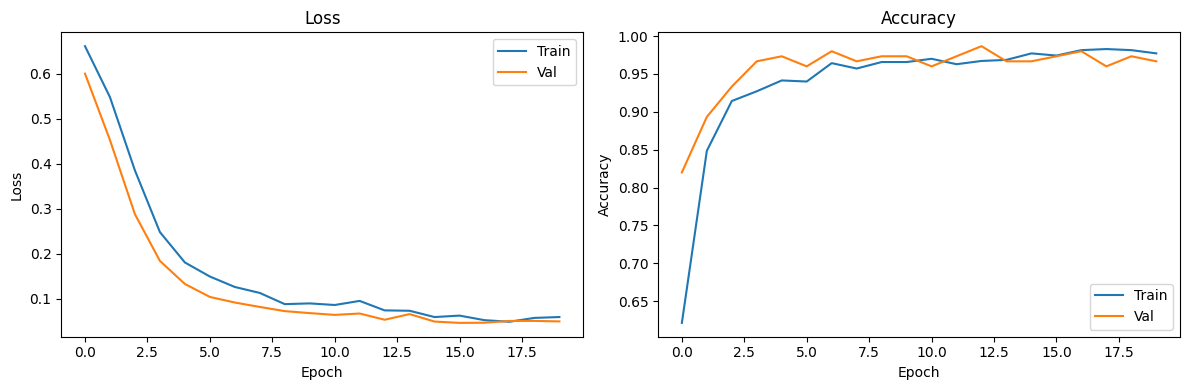

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# Final test evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.3f}")

Test Loss: 0.0987, Test Accuracy: 0.967


---

# Part 3: Early Stopping

---

In [11]:
class EarlyStopping:
    """Stop training when validation metric stops improving."""

    def __init__(self, patience=5, min_delta=0.001, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.should_stop = False

    def __call__(self, metric):
        if self.best_score is None:
            self.best_score = metric
            return False

        if self.mode == 'min':
            improved = metric < self.best_score - self.min_delta
        else:
            improved = metric > self.best_score + self.min_delta

        if improved:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

        return self.should_stop

# Usage
early_stopping = EarlyStopping(patience=5, mode='min')
# In training loop:
# if early_stopping(val_loss):
#     print("Early stopping triggered")
#     break

---

# Part 4: Complete Training Script Template

---

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler=None, n_epochs=50, device='cpu', patience=10):
    """Complete training function with all bells and whistles."""

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping = EarlyStopping(patience=patience, mode='min')

    for epoch in range(n_epochs):
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Learning rate scheduling
        if scheduler:
            scheduler.step()

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        # Print progress
        if (epoch + 1) % 5 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:3d} | LR: {lr:.6f} | "
                  f"Train: {train_loss:.4f}/{train_acc:.3f} | "
                  f"Val: {val_loss:.4f}/{val_acc:.3f}")

        # Early stopping
        if early_stopping(val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return history

---

# Key Points Summary

---

## Data Pipeline
- Create Dataset (`__len__`, `__getitem__`)
- Wrap in DataLoader (batching, shuffling)
- Split into train/val/test

## Training Loop
```python
model.train()
for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    output = model(X)
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

## Evaluation
- Use `model.eval()` and `@torch.no_grad()`
- Disable dropout and use running stats for BatchNorm

## Best Practices
- Save best model based on validation metric
- Use early stopping to prevent overfitting
- Track and plot training history

---

# Interview Tips

---

**Q: Why use DataLoader instead of iterating manually?**
A: DataLoader handles batching, shuffling, parallel loading, and memory pinning. It's optimized for GPU training.

**Q: Why call model.train() and model.eval()?**
A: These modes affect layers like Dropout and BatchNorm. Training mode enables dropout and accumulates BatchNorm stats. Eval mode disables dropout and uses fixed stats.

**Q: Why use @torch.no_grad() in evaluation?**
A: Disables gradient computation, saving memory and computation. We don't need gradients when not training.

---

## Next Module: [13 - Regularization](../13_regularization/13_regularization.ipynb)

Now let's learn techniques to prevent overfitting.